##### This notebook demonstrates a complete workflow for evaluating and tuning regression models, starting from data preprocessing to model selection, hyperparameter tuning, and final evaluation of the best model on the test set.

#### Poetry Libraries import

In [15]:
# Imports the necessary libraries and project-specific modules.
# --------------------------
# System and Utility Libraries
import joblib
import os
import sys
from pathlib import Path

# Data Manipulation Libraries
import numpy as np
import pandas as pd

# Machine Learning Algorithm Libraries
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Model Evaluation and Selection Libraries
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

# Model Interpretation Libraries
from sklearn.inspection import partial_dependence

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Project Specific Configuration and Utility Modules
import config
from config import RANDOM_SEED
from utils import DataPreprocessingPipeline

# Setting a random seed for reproducibility
config.set_seed()


In [2]:
# Load the raw data from the data/raw directory using the load_data method from the config module located at config.org
emergency_df = config.load_data('nhamcs14.sas7bdat', 'raw')
# Create a binary column where 2.0 in 'STAY24' is mapped to 1 mean ED discharge greater than 24 hours, and else 3.0 is mapped to 0.
emergency_df['STAY24'] = emergency_df['STAY24'].apply(lambda x: 1 if x == 2.0 else 0)

In [3]:
# Load and preprocess data using a custom pipeline defined in the utils module.
# Define the target variable and columns to drop
target = "LOV"
target_to_drop = ['LOV_BINARY', 'WAITTIME_BINARY']

# Initializing the data preprocessing pipeline
pipeline = DataPreprocessingPipeline(emergency_df=emergency_df, target=target,
                                     target_to_drop=target_to_drop, percent_train=0.70,
                                     percent_val=0.15, percent_test=0.15, stratify=False)

# Running the data preprocessing steps
pipeline.run()

# Extracting the preprocessed training, validation, and test sets
X_train_preprocessed = pipeline.X_train_preprocessed
X_validation_preprocessed = pipeline.X_validation_preprocessed
X_test_preprocessed = pipeline.X_test_preprocessed
y_train = pipeline.y_train
y_validation = pipeline.y_validation
y_test = pipeline.y_test

feature_names = pipeline.feature_names

cleaned_emergency_df = pipeline.cleaned_emergency_df 
transformed_emergency_df = pipeline.transformed_emergency_df

# Save the feature names for future reference
feature_names = [name.replace('num__', '').replace('cat__', '') for name in pipeline.feature_names]
feature_names_list = list(feature_names)
config.save_data(feature_names, f"features_{target}.csv", 'features')

1-Cleaning data...
Data cleaning completed
Size of Initial dataset:(23844, 1012)
Size of cleaned dataset:(22322, 370)

2-Applying feature engineering...
Feature engineering completed
Size of the dataset after feature engineering:(22322, 386)

3-Splitting data...
self.stratify: False
Splitting data completed

4-Loading data...
train_df size: (15625, 386)
X_train size: (15625, 385)
y_train size: (15625,)

validation_df size: (3348, 386)
X_validation size: (3348, 385)
y_validation size: (3348,)

test_df size: (3349, 386)
X_test size: (3349, 385)
y_test size: (3349,)
Loading data completed

5-Preprocessing data...
Preprocessing data completed.
Processor saved successfully


In [35]:
# Define Models for Evaluation
# ----------------------------
# Create a dictionary of default regression models to evaluate their performance.
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'LGBMRegressor': LGBMRegressor(random_state=42, force_col_wise=True, verbosity=-1),
    'CatBoostRegressor': CatBoostRegressor(verbose=0, random_seed=42)
}

# Implementing a ModelEvaluator class to evaluate and compare the performance of different models using cross-validation
# Evaluates the models, plots their performance, and saves the best model based on Mean Absolute Error (MAE)
# ----------------------
class ModelEvaluator:
    def __init__(self, models, X_train, y_train, cv=5):
        self.models = models
        self.X_train = X_train
        self.y_train = y_train
        self.cv = cv
        self.scorers = {'MAE': make_scorer(mean_absolute_error, greater_is_better=False), 'R2': 'r2'}

    def evaluate_models(self):
        """Evaluate all models and store their performance in a dictionary."""
        return {name: self._evaluate_model(model) for name, model in self.models.items()}

    def _evaluate_model(self, model):
        """Helper function to perform cross-validation and calculate MAE and R2."""
        cv_results = cross_validate(
            model, self.X_train, self.y_train, cv=self.cv, scoring=self.scorers
        )
        return {
            'MAE': -np.mean(cv_results['test_MAE']),
            'R2': np.mean(cv_results['test_R2'])
        }

    def plot_performance(self, performance):
        """Generate bar charts for MAE and R2 values of all models."""
        model_performance = {}
        for name, model in models.items():
            cv_results = cross_validate(model, X_train_preprocessed, y_train, cv=5,
                                        scoring=['neg_mean_absolute_error', 'r2'])
            mean_mae = -cv_results['test_neg_mean_absolute_error'].mean()
            mean_r2 = cv_results['test_r2'].mean()
            print(f"{name}:\n MAE: {mean_mae:.2f}, R-squared: {mean_r2:.2f}\n")
            model_performance[name] = mean_mae
            
   
        mae_values, r2_values = zip(*[(perf['MAE'], perf['R2']) for perf in performance.values()])
        
        # Sort the models based on MAE values in ascending order
        sorted_models = sorted(performance.keys(), key=lambda x: performance[x]['MAE'])
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Plot MAE values in sorted order
        ax1.barh(sorted_models, [performance[model]['MAE'] for model in sorted_models], color='skyblue', edgecolor='black')
        ax1.set(title='MAE Comparison', xlabel='MAE', ylabel='Models')
        ax1.invert_yaxis()
        
        # Plot R2 values in the same order as MAE
        ax2.barh(sorted_models, [performance[model]['R2'] for model in sorted_models], edgecolor='black', color='lightgreen')
        ax2.set(title='R2 Score Comparison', xlabel='R2 Score')
        ax2.invert_yaxis()
        
        plt.tight_layout()
        plt.show()

    def save_best_model(self, performance, directory="model_train"):
        """Identify the best model based on MAE and save it."""
        best_model_name = min(performance, key=lambda x: performance[x]['MAE'])
        best_model = self.models[best_model_name].fit(self.X_train, self.y_train)
        os.makedirs(directory, exist_ok=True)
        joblib.dump(best_model, os.path.join(directory, f"{best_model_name}.joblib"))
        print(f"Saved {best_model_name} model to {directory}")


Linear Regression:
 MAE: 56.94, R-squared: 0.52

Ridge Regression:
 MAE: 56.88, R-squared: 0.52

Lasso Regression:
 MAE: 58.39, R-squared: 0.50

Gradient Boosting:
 MAE: 52.98, R-squared: 0.57

XGBRegressor:
 MAE: 52.15, R-squared: 0.57

LGBMRegressor:
 MAE: 50.24, R-squared: 0.60

CatBoostRegressor:
 MAE: 49.85, R-squared: 0.61



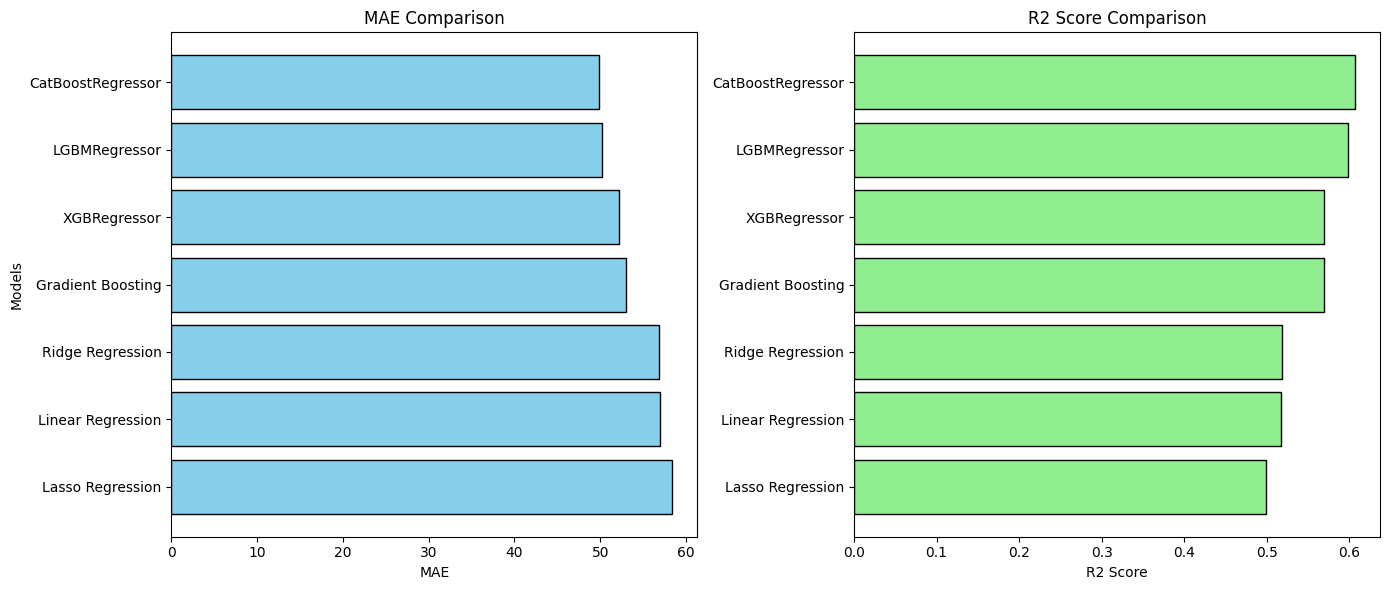

Saved CatBoostRegressor model to model_train


In [36]:
# Model Evaluation and Saving
# ---------------------------
evaluator = ModelEvaluator(models, pipeline.X_train_preprocessed, pipeline.y_train)
model_performance = evaluator.evaluate_models()
evaluator.plot_performance(model_performance)
evaluator.save_best_model(model_performance)

#### Key Findings and Insights:

##### Models Performance:

* The CatBoostRegressor outperforms all other regression models in terms of MAE (Mean Absolute Error) (49.85) and R2 Score (0.61), as shown in the Image above. This indicates that the CatBoostRegressor is the best-performing model for predicting the Length of Visit (LOV) in the emergency department.

* The LGBMRegressor and XGBRegressor also show relatively good performance compared to other models, suggesting that ensemble methods and gradient boosting techniques are effective for this prediction task.

In [6]:

# Load the saved best model
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/scripts/model_hyperparameter_tuning/model_train/"  # Absolute path to the model directory
model_filename = "CatBoostRegressor.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
trained_model = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")

In [7]:
# Implementing a ModelTuner class to tune the hyperparameters of the best model using GridSearchCV
# Defining the hyperparameter grid and scoring metric for tuning
# Tuneing the hyperparameters, evaluates the best model on the validation set, and saves the tuned model
class ModelTuner:
    def __init__(self, model, param_grid, scoring, cv=5, n_jobs=-1, verbose=2):
        self.model = model
        self.param_grid = param_grid
        self.scoring = scoring
        self.cv = cv
        self.n_jobs = n_jobs
        self.verbose = verbose
        self.grid_search = None
        self.best_model = None

    def tune_hyperparameters(self, X_train, y_train):
        """Tune hyperparameters using GridSearchCV."""
        self.grid_search = GridSearchCV(
            estimator=self.model,
            param_grid=self.param_grid,
            cv=self.cv,
            scoring=self.scoring,
            refit=True,
            verbose=self.verbose,
            n_jobs=self.n_jobs
        )
        self.grid_search.fit(X_train, y_train)
        self.best_model = self.grid_search.best_estimator_
        print("Best Hyperparameters:", self.grid_search.best_params_)
        print("Best Cross-Validation MAE:", -self.grid_search.best_score_)

    def evaluate(self, X_val, y_val):
        """Evaluate the best model on the validation set."""
        y_pred_validation = self.best_model.predict(X_val)
        mae_validation, r2_validation = mean_absolute_error(y_val, y_pred_validation), r2_score(y_val, y_pred_validation)
        print(f"Validation Set Performance:\nMAE: {mae_validation}\nR-squared: {r2_validation}")

    def save_model(self, model_directory, model_name):
        """Save the best model to the specified directory."""
        joblib.dump(self.best_model, os.path.join(model_directory, model_name))

# Define hyperparameter grid
param_grid = {
    'depth': [6, 8],
    'learning_rate': [0.01, 0.03, 0.1],
    'iterations': [1000],
    'l2_leaf_reg': [1, 3, 4]
}
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Tune hyperparameters, evaluate the best model, and save it
tuner = ModelTuner(trained_model, param_grid, scoring=mae_scorer)
tuner.tune_hyperparameters(X_train_preprocessed, y_train)
tuner.evaluate(X_validation_preprocessed, y_validation)
tuner.save_model("model_train", "CatBoostRegressor_tuned.joblib")


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.01; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.03; total time= 1.3min
[CV] END depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1; total time= 1.3min
[CV] END depth=6, iter

#### Keys findings and Insights 

#### Hyperparameter Tuning:

* The hyperparameters of the CatBoostRegressor model were tuned using a grid search approach to find the optimal combination of parameters that yields the best performance.

* The best hyperparameters found through tuning are:
'depth': 8
'iterations': 1000
'l2_leaf_reg': 1
'learning_rate': 0.03

* These hyperparameters control various aspects of the model, such as the depth of the decision trees, the number of iterations (trees) in the boosting process, the L2 regularization on leaf weights, and the learning rate.

* Model Performance before Tuning:
Before hyperparameter tuning, the CatBoostRegressor model achieved an MAE of 49.85 and an R-squared value of 0.61 on the validation set.

* On the validation set, the tuned model achieved an MAE of 49.57899240826773 and an R-squared value of 0.6144256171664682.

* The lower MAE value suggests that the tuned model makes more accurate predictions compared to the model before tuning. The slightly higher R-squared value indicates that the tuned model explains a larger proportion of the variance in the LOV.

* the hyperparameter tuning process has helped improve the performance of the CatBoostRegressor model for predicting the Length of Visit (LOV). By finding the optimal combination of hyperparameters, the model has achieved a lower MAE and a slightly higher R-squared value compared to the model before tuning. This indicates that the tuned model is better at making accurate predictions and explaining the variance in the LOV. 

* The insights gained from the tuning process, such as the impact of tree depth, the number of iterations, regularization, and learning rate, can guide further model development and deployment efforts.

In [8]:
# Loads the tuned model and evaluates its performance on the test set
model_train_dir = "/Users/Macbook/Desktop/EDPredictiveEfficiency/scripts/model_hyperparameter_tuning/model_train/"
model_filename = "CatBoostRegressor_tuned.joblib"
model_file_path = os.path.join(model_train_dir, model_filename)
trained_model = joblib.load(model_file_path) if os.path.exists(model_file_path) else print(f"No such file found: {model_file_path}")
# Make predictions on the test dataset
y_pred_test = trained_model.predict(X_test_preprocessed)
# Evaluate the final model's performance on the test dataset
mae_test = mean_absolute_error(pipeline.y_test, y_pred_test)
r2_test = r2_score(pipeline.y_test, y_pred_test)

print("Test Set Performance:")
print("MAE:", mae_test)
print("R-squared:", r2_test)

Test Set Performance:
MAE: 48.07857928787722
R-squared: 0.638253307503913


#### Insigths 

the tuned CatBoostRegressor model demonstrates excellent performance on the test set, with a low MAE and a high R-squared value. The model's ability to accurately predict the Length of Visit (LOV) on unseen data suggests its potential for real-world deployment in the emergency department. The insights gained from the test set evaluation, such as the model's predictive accuracy and generalization ability, can support informed decision-making and resource allocation strategies. The consistent performance between the validation set and the test set further validates the model's robustness and reliability.


Most important features (Importance >= 0.01):
             Feature  Importance
240           STAY24    0.133234
147          TOTDIAG    0.103913
2           WAITTIME    0.101359
368  ARRTIME_IN_HOUR    0.039085
365            CPSUM    0.020329
364          CSTRATM    0.017462
359          EMEDRES    0.015685
366            PATWT    0.014933
246         HOSPCODE    0.013731
156         IVFLUIDS    0.012670
183           NUMGIV    0.012348
220          BOARDED    0.011001
3                AGE    0.010051


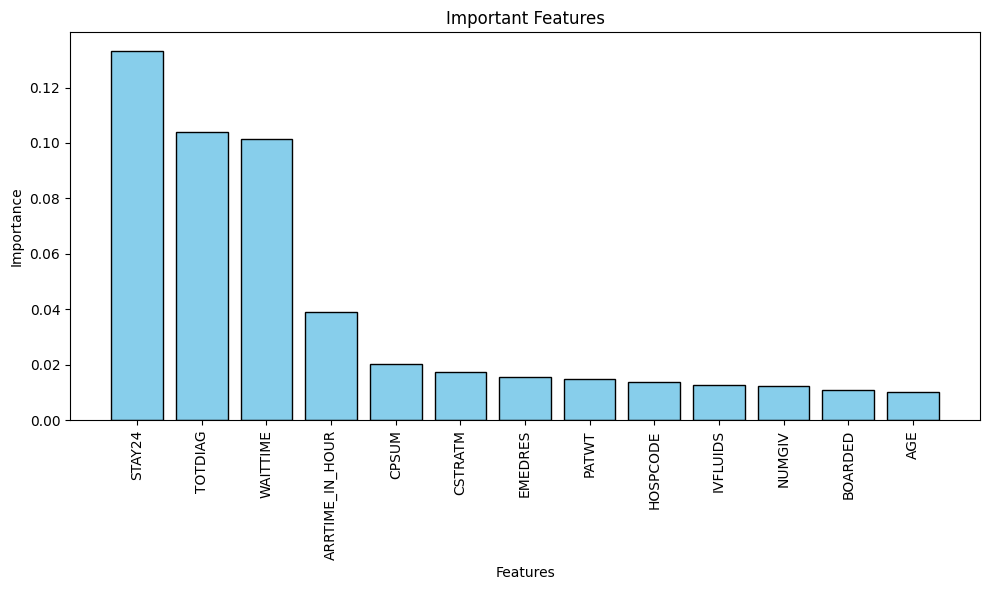

In [9]:
# Get feature importances from the trained model
feature_importances = trained_model.feature_importances_

# Normalize the feature importances
normalized_importances = feature_importances / np.sum(feature_importances)

# Create a dataframe with feature names and their normalized importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': normalized_importances})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Select the most important features based on a threshold
importance_threshold = 0.01
important_features_df = feature_importance_df[feature_importance_df['Importance'] >= importance_threshold]

print(f"\nMost important features (Importance >= {importance_threshold}):")
print(important_features_df)

# Plot the important features
plt.figure(figsize=(10, 6))
plt.bar(important_features_df['Feature'], important_features_df['Importance'], color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Important Features')
plt.tight_layout()
plt.show()


#### Important Features insights


* We highlights the most important features that impact the Length of Visit (LOV) prediction. The top three features are STAY24, TOTDIAG, and WAITTIME.

* STAY24, which represents "1 : ED discharge greater than 24 hours,0 : otherwise", has the highest importance, suggesting that it is a crucial factor in determining the LOV.

* TOTDIAG, indicating the total number of diagnostic services ordered or provided, and WAITTIME, representing the waiting time to see MD/DO/PA/NP in minutes, also have significant importance in predicting LOV.

* Other features such as ARRTIME_IN_HOUR (Arrival time), CPSUM (Clustered Primary Sampling Unit marker (masked)), and CSTRATM also contribute to the prediction, the others one with lower importance compared to the top features.

* The heatmap below offers a snapshot of how different features relate to the Length of Visit (LOV).

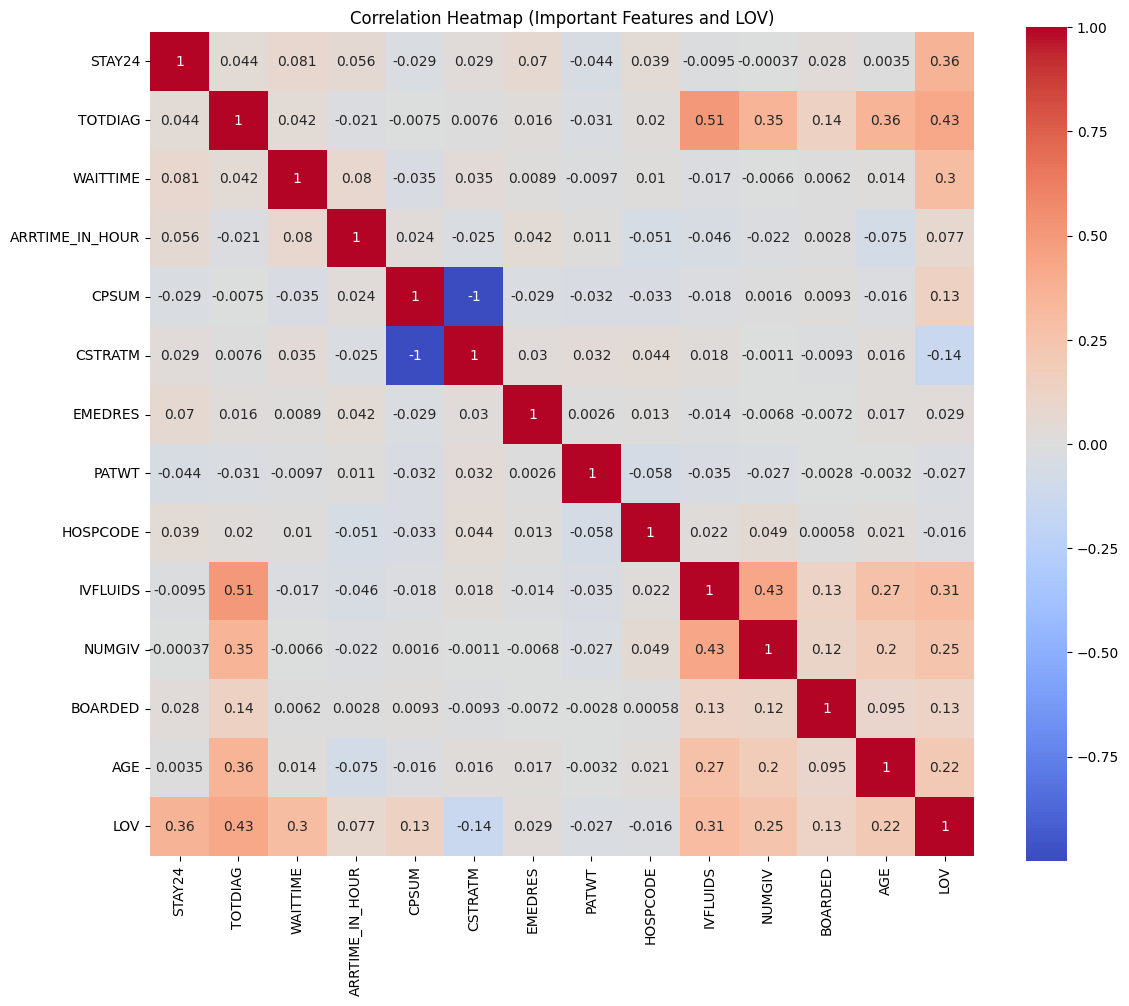

In [10]:
# Create a new DataFrame with the most important features and the target variable (LOV)
important_features_list = important_features_df['Feature'].tolist()
important_features_target_df = transformed_emergency_df[important_features_list + [target]]

# Calculate the correlation matrix
correlation_matrix = important_features_target_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Heatmap (Important Features and LOV)')
plt.tight_layout()
plt.show()



In [11]:
# Get the indices of the most important features in the preprocessed test set
important_feature_indices = [feature_names_list.index(feature) if feature in feature_names_list else None for feature in important_features_list]
# Select the most important features from the test set using indices and handle missing features
X_test_important_features = X_test_preprocessed[:, important_feature_indices]
X_train_selected_features = X_train_preprocessed[:, important_feature_indices]

In [23]:
trained_model.fit(X_train_selected_features, y_train)
# Evaluate the best model on the test set using only the most important features
y_pred_test_top = trained_model.predict(X_test_important_features)
mae_test_important_features = mean_absolute_error(y_test, y_pred_test_top)
r2_test_important_features = r2_score(y_test, y_pred_test_top)

print("\nTest Set Performance (Important Features):")
print("MAE:", mae_test_important_features)
print("R-squared:", r2_test_important_features)


Test Set Performance (Important Features):
MAE: 50.550393102048396
R-squared: 0.6016501614932714


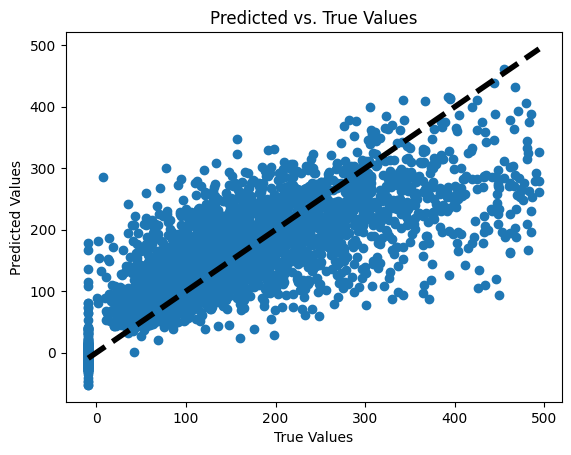

In [24]:
plt.scatter(y_test, y_pred_test_top)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs. True Values')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.show()

#### Predicted vs. True Values Scatter Plot insight:

* The scatter plot demonstrates a positive linear relationship between the predicted and true values, with most predictions closely aligned with the actual LOV, especially for lower values of LOV.

* The dashed line, representing the ideal prediction, is close to many of the data points, indicating a good model fit for a significant portion of the predictions. However, there is a spread as the LOV increases, suggesting that the model may be less accurate for longer LOV predictions.

/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'values', is deprecated in 1.3 and will be removed in 1.5. Please use 'grid_values' instead.
  warnings.warn(
/Users/Macbook/Library/Caches/pypoetry/virtualenvs/edpredictiveefficiency-6OWGp70p-py3.11/lib/python3.11/site-packages/sklearn/utils/_bunch.py:35: FutureWarning: Key: 'v

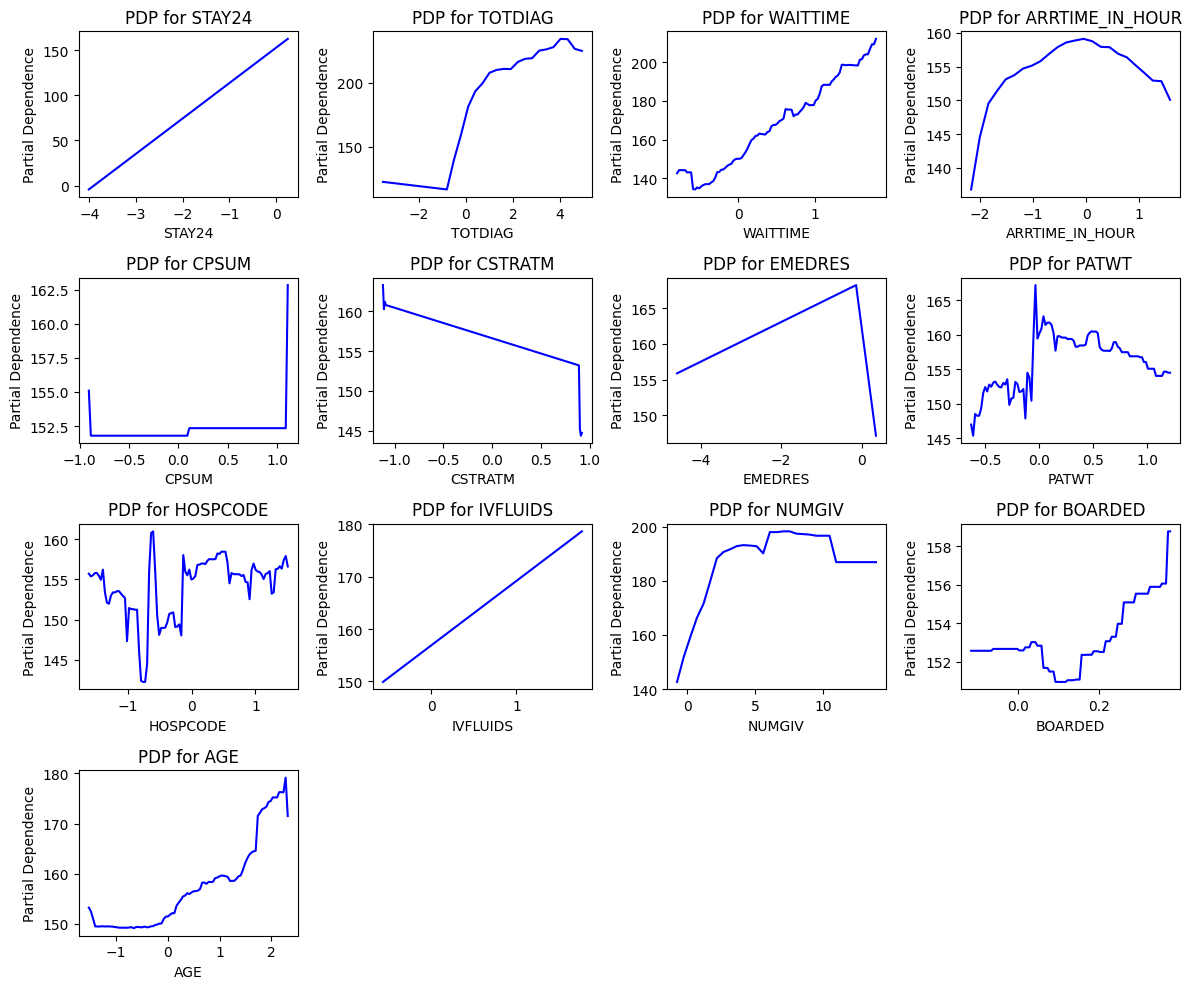

In [26]:
# Convert X_train_selected_features to a pandas DataFrame
X_train_important_features_df = pd.DataFrame(X_train_selected_features, columns=important_features_list)

plt.figure(figsize=(12, 10))
for i, feature in enumerate(important_features_list, 1):
    ax = plt.subplot(4, 4, i)
    
    # Generate partial dependence data
    pd_data = partial_dependence(trained_model, X_train_important_features_df, [feature])
    
    # Extract the partial dependence values and the feature values
    pd_values = pd_data['average'][0]
    feature_values = pd_data['values'][0]
    
    # Plot the partial dependence
    ax.plot(feature_values, pd_values, color='blue')
    
    # Set the title and labels for each subplot
    ax.set_title(f"PDP for {feature}")
    ax.set_xlabel(feature)
    ax.set_ylabel("Partial Dependence")

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Display the plots
plt.tight_layout()
plt.show()

#### getting insights from Partial Dependence Plots (PDPs):

* PDPs show the relationship between the feature and the predicted outcome, holding all other features constant.

* For examples for features like IVFLUIDS, STAY24, TOTDIAG, there’s a positive slope, indicating that increases in these variables are associated with longer predicted LOVs. This suggests that older patients and those requiring more IV fluids tend to have longer emergency department stays.

* Interestingly, features such as EMEDRES (emergency medicine residents) show a sharp decrease in influence on LOV after a certain point, which could imply that resident involvement has a threshold after which additional presence does not significantly affect LOV.

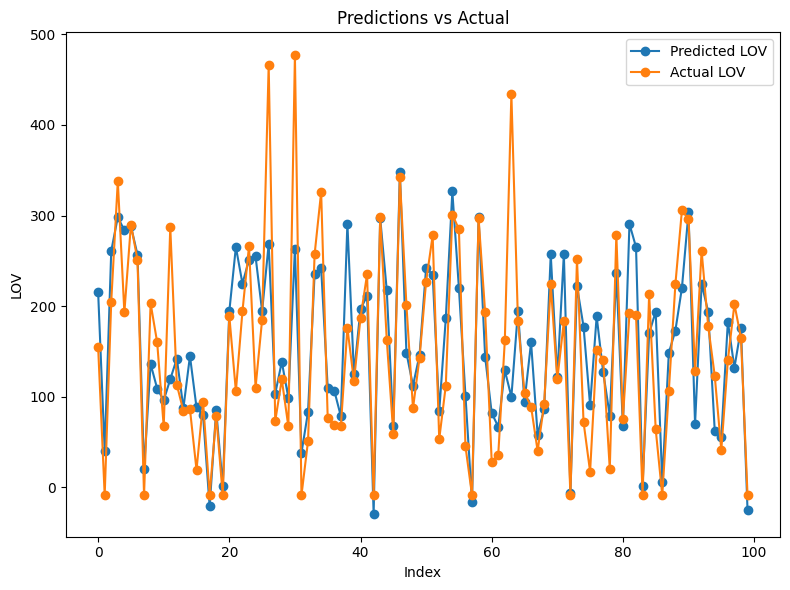

In [32]:
predicted_lov = y_pred_test[:100]  # List of 100 predicted LOV values
actual_lov = pipeline.y_test[:100]  # List of actual LOV values

# Create a list of indices for the x-axis
indices = list(range(len(predicted_lov)))

# Create the plot
plt.figure(figsize=(8, 6))  
plt.plot(indices, predicted_lov, label='Predicted LOV', marker='o')
plt.plot(indices, actual_lov, label='Actual LOV', marker='o')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('LOV')
plt.title('Predictions vs Actual')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()

Predictions vs Actual Line Plot:

* This plot illustrates the fluctuation of both the actual and predicted LOV for individual cases. The closeness of the two lines in many areas suggests the model is generally effective in tracking the actual trends.

* However, there are noticeable divergences at several points where the predicted values either underestimate or overestimate the actual LOV, indicating areas where the model could be improved.

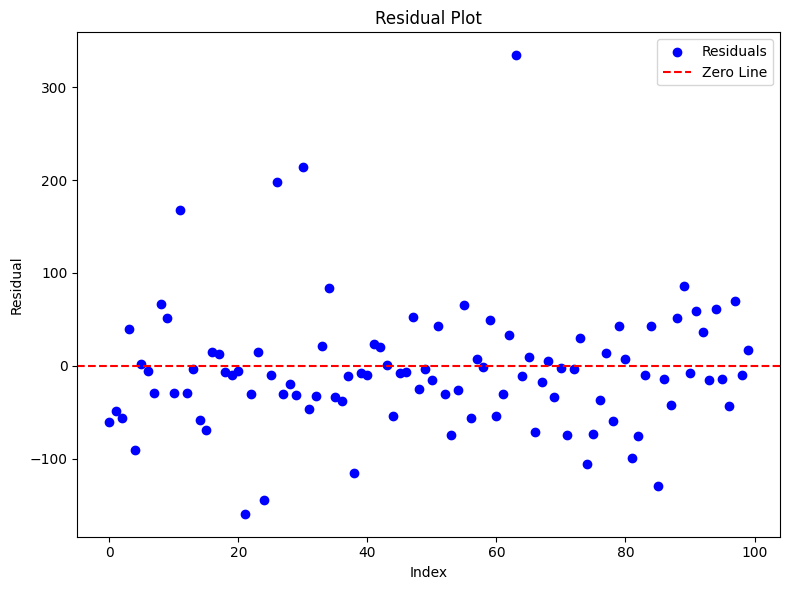

In [34]:
# Calculate the residuals
residuals = [actual - predicted for actual, predicted in zip(actual_lov, predicted_lov)]

# Create a list of indices for the x-axis
indices = list(range(len(predicted_lov)))

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed

# Plot the residuals
plt.scatter(indices, residuals, color='blue', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--', label='Zero Line')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Residual')
plt.title('Residual Plot')

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()